<a href="https://colab.research.google.com/github/cerr/CT_SwallowingAndChewing_DeepLabV3/blob/master/demo_DLseg_swallowing_and_chewing_structures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Deep learning-based segmentation of Swallowing and Chewing structures in H&N CT scans




## Introduction
This notebook demonstrates the application of a Convolution Neural Network model to segment the following swallowing and chewing structures in H&N CT scans. 

*   Masseters (left, right)
*   Medial pterygoid (left, right)
*   Larynx_DLabV3
*   Constrictor muscle  

#### *Reference*
Model details are available in Iyer, A, et al. "Prospectively-validated deep learning model for segmenting swallowing and chewing structures in CT" in *Physics in Medicine & Biology* (2021). DOI:[10.1088/1361-6560/ac4000](https://doi.org/10.1088/1361-6560/ac4000).

---

## Requirements
* GNU Octave with *image*, *statistics*, and *io* packages
* Oct2Py
* [CERR](https://github.com/cerr/CERR)
* [Pre-trained segmentation models](https://github.com/cerr/CT_SwallowingAndChewing_DeepLabV3/releases)
* Python with *matplotlib*, "*numpy*, *ipywidgets* packages

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import ipywidgets as widgets

*Note*: Installing these tools may incur a one-time extra runtime overhead.

##I/O

In this example, we use sample images in CERR's native planC format (imported from DICOM) to delineate the swallowing and chewing structures. Segmentation masks are output to Octave matrix and numpy formats.

## Results

This notebook comes with a static visualization of a sample filter output. A second interactive display section is additionally made available on running the notebook.

## Install latest Octave compile



In [1]:
%%capture
! apt-get update
! apt-get install gcc g++ gfortran make libblas-dev liblapack-dev libpcre3-dev \
libarpack2-dev libcurl4-gnutls-dev epstool libfftw3-dev transfig libfltk1.3-dev \
libfontconfig1-dev libfreetype6-dev libgl2ps-dev libglpk-dev libreadline-dev \
gnuplot-x11 libgraphicsmagick++1-dev libhdf5-serial-dev openjdk-8-jdk \
libsndfile1-dev llvm-dev lpr texinfo libgl1-mesa-dev libosmesa6-dev pstoedit \
portaudio19-dev libqhull-dev libqrupdate-dev libqscintilla2-dev \
libsuitesparse-dev texlive texlive-generic-recommended libxft-dev zlib1g-dev \
autoconf automake bison flex gperf gzip icoutils librsvg2-bin libtool perl \
rsync tar qtbase5-dev qttools5-dev qttools5-dev-tools libqscintilla2-qt5-dev \
wget git libsundials-dev gnuplot x11-apps

In [2]:
import os, urllib.request, json

In [3]:
# Download latest compiled octave package 
def get_octave(root_path):
  os.chdir(root_path)
  with urllib.request.urlopen("https://api.github.com/repos/cerr/octave-colab/releases/latest") as url:
      data = json.loads(url.read().decode())
  fname = data['assets'][0]['name']
  requrl = data['assets'][0]['browser_download_url']
  urllib.request.urlretrieve(requrl, fname)
  # Unzip, identify octave folder name
  !tar xf {fname}
  top_folder = !tar tf {fname} | head -1
  octave_folder = top_folder[0][:-1]
  octave_path = os.path.join(root_path,octave_folder)
  return octave_path

# Set path to Octave exectuable
octave_path = get_octave('/content')
os.environ['OCTAVE_EXECUTABLE'] = octave_path + '/bin/octave-cli'
os.environ['PATH'] = octave_path + '/bin:' + os.environ['PATH']

## Install Python-Octave bridge

In [4]:
%%capture
! pip3 install octave_kernel
! pip3 install oct2py==5.3.0

%load_ext oct2py.ipython

## Download CERRx

In [5]:
%%capture
!git clone --single-branch --branch octave_dev https://www.github.com/cerr/CERR.git
import os
currDir = os.getcwd()
os.chdir("/content/CERR")
#!git checkout 2847d7df4a889c2ebd9c93a9d25bf46fd2ee75be
os.chdir(currDir)

In [6]:
%cd /content/CERR
!git pull
!git status

## Download pretrained models

In [7]:
%%capture
%%bash
LOCATION=$(curl -s https://api.github.com/repos/aditiiyer/CT_SwallowingAndChewing_DeepLabV3/tags \
| grep "name"| grep "linux" \
| awk '{print "https://github.com/aditiiyer/CT_SwallowingAndChewing_DeepLabV3/archive/" substr($2, 2, length($2)-3) ".zip"}') \
; curl -L -o swallowChewSeg.zip $LOCATION

unzip swallowChewSeg.zip -d pretrained

## Apply segmentation models to sample data

In [8]:
%%capture
from oct2py import octave

octave.eval('pkg load image')
octave.eval('pkg load io')
octave.eval('pkg load statistics')
octave.addpath(octave.genpath('/content/CERR'))

In [9]:
## Load sample data
sampleData = '/content/CERR/Unit_Testing/data_for_cerr_tests/' + \
              'CERR_plans/head_neck_ex1_20may03.mat.bz2'

%octave_push sampleData
planC = octave.loadPlanC(sampleData, octave.tempdir())
planC = octave.updatePlanFields(planC)
planC = octave.quality_assure_planC(sampleData, planC)

In [10]:
## Apply auto-segmentation models
algorithm = 'CT_ChewingStructures_DeepLabV3^CT_Larynx_DeepLabV3^' + \
            'CT_PharyngealConstrictor_DeepLabV3';
sessionPath = '/content/temp/'
condaEnvName = '/content/pretrained/CT_SwallowingAndChewing_DeepLabV3-1.0-linux/'
cmdFlag = 'condaEnv'
newSessionFlag = 1

planC = octave.runAIforPlanC(planC,sessionPath,algorithm,cmdFlag, \
    newSessionFlag,[],[],condaEnvName)

## Get segmentation masks

In [11]:
from oct2py import octave
%octave_push planC

In [12]:
%%octave

addpath(genpath('/content/CERR'))

%Get scan array
indexS = planC{end};
scanNum = 1;
ctOffset = planC{indexS.scan}(scanNum).scanInfo(1).CTOffset;
scanArray = single(getScanArray(scanNum,planC)) - ctOffset;

%Get structure labels & masks
numStructs = length(planC{indexS.structures});
structNameC = {planC{indexS.structures}.structureName};
strNameC = {'Left_masseter', 'Right_masseter', 'Left_medial_pterygoid',...
              'Right_medial_pterygoid', 'Larynx_DLabV3', 'Constrictor_muscle'};
for strNum = 1:length(strNameC)
    strx = strNameC{strNum};
    idx = getMatchingIndex(strx,structNameC,'EXACT');
    mask3M = getStrMask(idx, planC);
    maskC{strNum} = mask3M;
end

## Display auto-segmentation results using Python/Matplotlib

In [13]:
%octave_pull maskC strNameC scanArray

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import ipywidgets as widgets

dx, dy = 1, 1

x = np.arange(0, 255, dx)
y = np.arange(0, 255, dy)
extent = np.min(x), np.max(x), np.min(y), np.max(y)

cmaps = [plt.cm.Oranges,plt.cm.Oranges,plt.cm.Blues,plt.cm.Blues, \
             plt.cm.Purples,plt.cm.Greens]

clear_output(wait=True)

def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

**Example: display center slice**


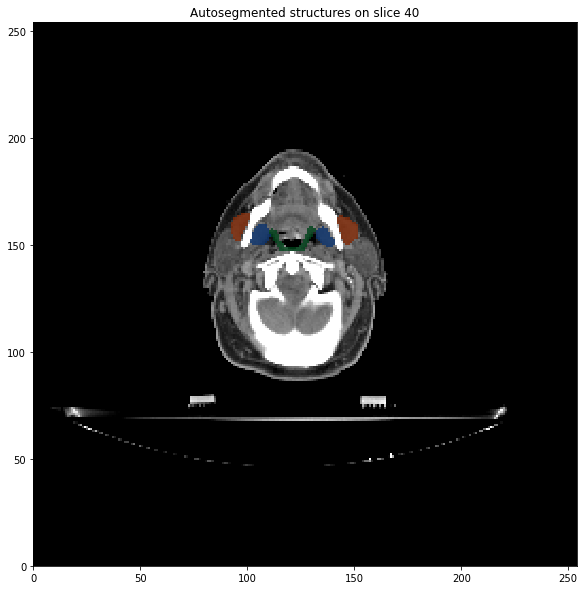

In [15]:
# Plot center slice
scanSize = np.shape(scanArray)
centerSlc = np.round(scanSize[2]/2).astype(int)

window_center = 40
window_width = 400
fig, ax = plt.subplots(1,1,figsize=(10,10))

windowed_img = window_image(scanArray[:,:,centerSlc],
                                window_center,window_width)
ax.imshow(windowed_img, cmap=plt.cm.gray, alpha=1,
                    interpolation='nearest', extent=extent)
ax.title.set_text('Auto-segmented structures on slice ' + str(centerSlc))
fontdict = {'fontsize' : 100}

for maskNum in range(0,6,1):
        mask_cmap = cmaps[maskNum]
        mask_cmap.set_under('k', alpha=0)
        im2 = ax.imshow(maskC[0,maskNum][:,:,centerSlc-1], 
                        cmap=mask_cmap, alpha=.8, extent=extent,
                        interpolation='none', clim=[0.5, 1])   

**Interactive display**

In [16]:
def show_axial_slice(slcNum):
    clear_output(wait=True)
    print('Slice '+str(slcNum))
    if 'fig' in locals():
        fig.remove()
    fig, ax = plt.subplots(1,1,figsize=(10,10))

    window_center = 45
    window_width = 125
    windowed_img = window_image(scanArray[:,:,slcNum-1],
                                window_center,window_width)
    im1 = ax.imshow(windowed_img, cmap=plt.cm.gray, alpha=1,
                    interpolation='nearest', extent=extent)
    
    cmaps = [plt.cm.Oranges,plt.cm.Oranges,plt.cm.Blues,plt.cm.Blues, \
             plt.cm.Purples,plt.cm.Greens]

    for maskNum in range(0,6,1):
        mask_cmap = cmaps[maskNum]
        mask_cmap.set_under('k', alpha=0)
        im2 = ax.imshow(maskC[0,maskNum][:,:,slcNum-1], 
                        cmap=mask_cmap, alpha=.8, extent=extent,
                        interpolation='none', clim=[0.5, 1])        
    plt.show()

slice_slider = widgets.IntSlider(value=30,min=1,max=79,step=1)
outputSlc = widgets.Output()

display(slice_slider, outputSlc)


def update_slice(change):
    with outputSlc:
        show_axial_slice(change['new'])

slice_slider.observe(update_slice, names='value')